<a href="https://colab.research.google.com/github/santule/ERA/blob/main/S18P1/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. UNET MODEL IN PYTORCH FOR 3 CLASSES AND CROSS ENTROPY/DICE LOSS.

2. TRAINED FOR 20 EPOCHS

# 0 - INSTALL AND LOAD LIBARRIES

In [ ]:
!pip install torchinfo --quiet
!pip install matplotlib --quiet
!pip install imageio --quiet

In [ ]:
from torchinfo import summary
import torch.nn as nn
import torch
import os
import matplotlib.pyplot as plt
import imageio
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F
import torchvision
import multiprocessing
import torchvision.transforms as T

# 1 - DEFINE UNET MODEL

In [ ]:
class ContractingBlock(nn.Module):

  def __init__(self,in_channels,out_channels,StrConv,pooling=True):
    super(ContractingBlock,self).__init__()

    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.ReLU(inplace=True)

    self.maxpool  = nn.MaxPool2d(kernel_size=2,stride=2)
    self.str_conv = nn.Conv2d(out_channels, out_channels, kernel_size=2, stride=2)

    self.pooling  = pooling
    self.StrConv  = StrConv

  def forward(self,x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)

    skip = x
    if self.pooling:
      if self.StrConv:
        x = self.str_conv(x)
      else:
        x = self.maxpool(x)

    return x, skip

class ExpandingBlock(nn.Module):

  def __init__(self,in_channels,out_channels,ConvTr):
    super(ExpandingBlock,self).__init__()

    self.conv2d_tr = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
    self.upsample  = nn.Upsample(scale_factor = 2, mode='bilinear')
    self.conv2d    = nn.Conv2d(in_channels,in_channels //2,kernel_size=1)

    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1) # 512,256
    self.bn1   = nn.BatchNorm2d(out_channels)
    self.relu1 = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3, padding=1) # 256,256
    self.bn2   = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.ReLU(inplace=True)
    self.ConvTr = ConvTr

  def forward(self,x,skip):

    if self.ConvTr:
      x = self.conv2d_tr(x)
    else:
      x = self.upsample(x)
      x = self.conv2d(x)

    #print("skip",skip.shape)
    x = torch.cat((x,skip),dim = 1) # dimension 1 is the channel
    #print("after concatenation",x.shape)

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    #print("after expanding",x.shape)

    return x

class Unet(nn.Module):

  def __init__(self,in_channels,out_channels,StrConv,ConvTr):
    super(Unet,self).__init__()

    self.contract1 = ContractingBlock(in_channels,32,StrConv)
    self.contract2 = ContractingBlock(32,64,StrConv)
    self.contract3 = ContractingBlock(64,128,StrConv)
    self.contract4 = ContractingBlock(128,256,StrConv)
    self.contract5 = ContractingBlock(256,512,StrConv=False,pooling=False)

    self.expand1 = ExpandingBlock(512,256,ConvTr)
    self.expand2 = ExpandingBlock(256,128,ConvTr)
    self.expand3 = ExpandingBlock(128,64,ConvTr)
    self.expand4 = ExpandingBlock(64,32,ConvTr)

    self.final_conv = nn.Conv2d(32, out_channels,kernel_size=1)

  def forward(self,x):
    x,skip1 = self.contract1(x)
    #print(x.shape,skip1.shape) # torch.Size([1, 32, 64, 64]) torch.Size([1, 32, 128, 128])

    x,skip2 = self.contract2(x)
    #print(x.shape,skip2.shape) # torch.Size([1, 64, 32, 32]) torch.Size([1, 64, 64, 64])

    x,skip3 = self.contract3(x)
    #print(x.shape,skip3.shape) # torch.Size([1, 128, 16, 16]) torch.Size([1, 128, 32, 32])

    x,skip4 = self.contract4(x)
    #print(x.shape,skip4.shape) # torch.Size([1, 256, 8, 8]) torch.Size([1, 256, 16, 16])

    x,skip5 = self.contract5(x)
    #print(x.shape,skip5.shape) # torch.Size([1, 512, 4, 4]) torch.Size([1, 512, 8, 8])

    x = self.expand1(x,skip4) # after upsample torch.Size([1, 256, 16, 16]) , skip torch.Size([1, 256, 16, 16]), after concatenation torch.Size([1, 512, 16, 16]), after expanding torch.Size([1, 256, 16, 16])
    #print(x.shape)
    x = self.expand2(x,skip3) # after upsample torch.Size([1, 128, 32, 32]), skip torch.Size([1, 128, 32, 32]), after concatenation torch.Size([1, 256, 32, 32]), after expanding torch.Size([1, 128, 32, 32])
    #print(x.shape)
    x = self.expand3(x,skip2) # after upsample torch.Size([1, 64, 64, 64]) , skip torch.Size([1, 64, 64, 64]) , after concatenation torch.Size([1, 128, 64, 64]), after expanding torch.Size([1, 64, 64, 64])
    #print(x.shape)
    x = self.expand4(x,skip1) # after upsample torch.Size([1, 32, 128, 128]), skip torch.Size([1, 32, 128, 128]), after concatenation torch.Size([1, 64, 128, 128]), after expanding torch.Size([1, 32, 128, 128])
    #print(x.shape)

    x = self.final_conv(x)
    #print(x.shape)
    return x

In [ ]:
my_unet = Unet(in_channels=3, out_channels=3,StrConv=True,ConvTr=False)
summary(model= my_unet, input_size=(32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                              [32, 3, 128, 128]    [32, 3, 128, 128]    --                   True
├─ContractingBlock (contract1)           [32, 3, 128, 128]    [32, 32, 64, 64]     --                   True
│    └─Conv2d (conv1)                    [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
│    └─BatchNorm2d (bn1)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu1)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (conv2)                    [32, 32, 128, 128]   [32, 32, 128, 128]   9,248                True
│    └─BatchNorm2d (bn2)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu2)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (str

# 2 - LOAD AND SAMPLE DATA

In [ ]:
working_dir = '/content/data'

# Oxford IIIT Pets Segmentation dataset loaded via torchvision.
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

100%|██████████| 791918971/791918971 [00:36<00:00, 21598467.13it/s]


Extracting /content/data/OxfordPets/train/oxford-iiit-pet/images.tar.gz to /content/data/OxfordPets/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10904548.29it/s]


Extracting /content/data/OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to /content/data/OxfordPets/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:37<00:00, 21248367.22it/s]


Extracting /content/data/OxfordPets/test/oxford-iiit-pet/images.tar.gz to /content/data/OxfordPets/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 11724297.37it/s]


Extracting /content/data/OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to /content/data/OxfordPets/test/oxford-iiit-pet


Text(0.5, 1.0, 'Masked Image 1')

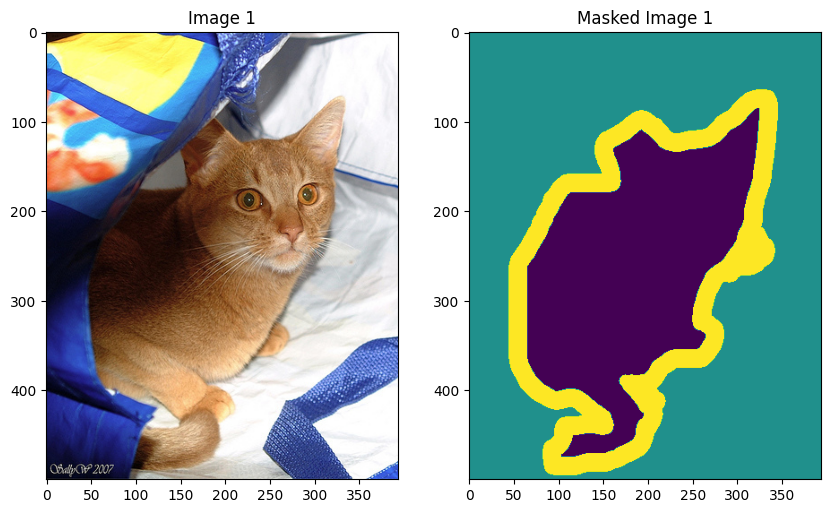

In [ ]:
# sample image
fig, arr = plt.subplots(1, 2, figsize=(10, 10))
arr[0].imshow(pets_train_orig[0][0])
arr[0].set_title('Image '+ str(1))
arr[1].imshow(pets_train_orig[0][1])
arr[1].set_title('Masked Image '+ str(1))

# 3 - DATASET AND DATA LOADER

In [ ]:
IMG_SIZE    = 128
BATCH_SIZE  = 16
NUM_WORKERS = int(multiprocessing.cpu_count() / 2)

In [ ]:
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE), interpolation=T.InterpolationMode.NEAREST),
    transforms.ToTensor(),  # normalises by default and converts to tensor
])

class OxfordDataset(torchvision.datasets.OxfordIIITPet):
  def __init__(self,
               root: str,
        split: str,
        target_types="segmentation",
        download=False,transform=None):

    super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=transform,
        )
    self.transform = transform

  def __len__(self):
    return super().__len__()

  def __getitem__(self,index):
    (img, mask_img) = super().__getitem__(index) # img is already a tensor
    mask_img = self.transform(mask_img)
    mask_img = mask_img * 255
    mask_img = mask_img.to(torch.long)
    mask_img = mask_img - 1
    return (img, mask_img)

petdata_train = OxfordDataset(root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,transform = manual_transform)

petdata_test = OxfordDataset(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    transform = manual_transform,
)

In [ ]:
# DATALOADERS
train_dataloader = DataLoader(petdata_train,batch_size = BATCH_SIZE,
                              shuffle=True,num_workers=NUM_WORKERS,
                              pin_memory=True)
test_dataloader = DataLoader(petdata_test,batch_size = BATCH_SIZE,
                              shuffle=False,num_workers=NUM_WORKERS,
                              pin_memory=True)

In [ ]:
# check the shape
(train_pets_inputs, train_pets_targets) = next(iter(train_dataloader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16, 1, 128, 128]))

# 4 - DEFINE TRAINING AND LOSS FUNCTIONS

In [ ]:
EPOCHS = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def train_unet(EPOCHS,my_unet,loss_fn,device,train_dataloader,test_dataloader):
  train_losses,test_losses = [],[]

  for epoch in tqdm(range(EPOCHS)):

    my_unet.train()
    train_loss = 0
    for batch, (X,y) in enumerate(train_dataloader):
      X,y = X.to(device), y.to(device)
      y_pred = my_unet(X)

      loss = loss_fn(y_pred,y.squeeze(1))
      train_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    train_loss = train_loss / len(train_dataloader)

    # test model
    my_unet.eval()
    test_loss = 0

    with torch.inference_mode():
      for batch, (X,y) in enumerate(test_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred = my_unet(X)

        loss = loss_fn(y_pred,y.squeeze(1))
        test_loss += loss.item()

      test_loss = test_loss / len(test_dataloader)

    print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"test_loss: {test_loss:.4f} "
          )
    train_losses.append(train_loss)
    test_losses.append(test_loss)

  return train_losses,test_losses

In [ ]:
# define losses
ce_loss_fn = nn.CrossEntropyLoss()

def dice_loss_fn(pred,target,n_classes=3):
  smooth = 0.001
  pred = F.softmax(pred,dim=1).float().flatten(0,1) # (96,128,128)-> 3 * 32
  target = F.one_hot(target, n_classes).squeeze(1).permute(0, 3, 1, 2).float().flatten(0,1) # (96,128,128) -> 3 * 32
  assert pred.size() == pred.size(), "sizes do not match"

  intersection = 2 * (pred * target).sum(dim=(-1, -2)) # 96
  union = pred.sum(dim=(-1, -2)) + target.sum(dim=(-1, -2)) #96
  #sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

  dice = (intersection + smooth) / ( union + smooth)

  return 1 - dice.mean()

In [ ]:
# define plot losses
def plot_losses(train_losses,test_losses,title):
  %matplotlib inline
  fig, axs = plt.subplots(1,2,figsize=(9,3))
  axs[0].plot(train_losses)
  axs[0].set_title("Training Loss")
  axs[1].plot(test_losses)
  axs[1].set_title("Test Loss")
  fig.suptitle(title)

# 5.1 - TRAIN THE UNET MODEL  - MP + Tr + BCE (cross entropy loss)

In [ ]:
my_unet = Unet(in_channels=3, out_channels=3, StrConv=False, ConvTr=True).to(device)
optimizer = torch.optim.Adam(params = my_unet.parameters(),lr=0.001)

print(summary(model= my_unet, input_size = (32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]))
train_losses,test_losses = train_unet(EPOCHS,my_unet,ce_loss_fn,device,train_dataloader,test_dataloader)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                              [32, 3, 128, 128]    [32, 3, 128, 128]    --                   True
├─ContractingBlock (contract1)           [32, 3, 128, 128]    [32, 32, 64, 64]     4,128                True
│    └─Conv2d (conv1)                    [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
│    └─BatchNorm2d (bn1)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu1)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (conv2)                    [32, 32, 128, 128]   [32, 32, 128, 128]   9,248                True
│    └─BatchNorm2d (bn2)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu2)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─MaxPool2d (

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6169 | test_loss: 0.5951 
Epoch: 2 | train_loss: 0.4764 | test_loss: 0.4382 
Epoch: 3 | train_loss: 0.4056 | test_loss: 0.3831 
Epoch: 4 | train_loss: 0.3685 | test_loss: 0.3478 
Epoch: 5 | train_loss: 0.3429 | test_loss: 0.3497 
Epoch: 6 | train_loss: 0.3229 | test_loss: 0.3329 
Epoch: 7 | train_loss: 0.3080 | test_loss: 0.3389 
Epoch: 8 | train_loss: 0.2931 | test_loss: 0.3275 
Epoch: 9 | train_loss: 0.2797 | test_loss: 0.3409 
Epoch: 10 | train_loss: 0.2656 | test_loss: 0.3158 
Epoch: 11 | train_loss: 0.2582 | test_loss: 0.2896 
Epoch: 12 | train_loss: 0.2471 | test_loss: 0.2982 
Epoch: 13 | train_loss: 0.2389 | test_loss: 0.3016 
Epoch: 14 | train_loss: 0.2287 | test_loss: 0.2778 
Epoch: 15 | train_loss: 0.2176 | test_loss: 0.2981 
Epoch: 16 | train_loss: 0.2190 | test_loss: 0.2972 
Epoch: 17 | train_loss: 0.2031 | test_loss: 0.2963 
Epoch: 18 | train_loss: 0.1978 | test_loss: 0.2797 
Epoch: 19 | train_loss: 0.1911 | test_loss: 0.2832 
Epoch: 20 | train_los

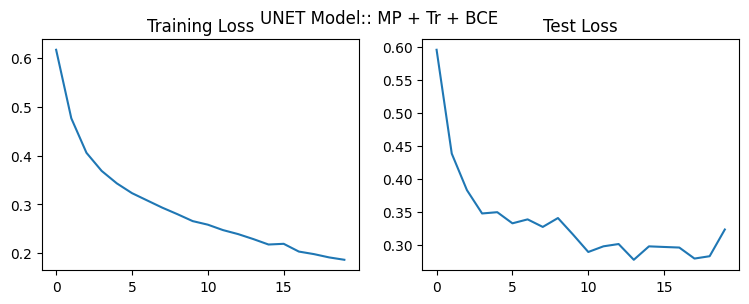

In [ ]:
plot_losses(train_losses,test_losses,title = "UNET Model:: MP + Tr + BCE")

# 5.2 - TRAIN THE UNET MODEL  - MP + Tr + Dice Loss

In [ ]:
my_unet = Unet(in_channels=3, out_channels=3,StrConv=False,ConvTr=True).to(device)
optimizer = torch.optim.Adam(params = my_unet.parameters(),lr=0.001)
print(summary(model= my_unet, input_size=(32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]))
train_losses,test_losses =  train_unet(EPOCHS,my_unet,dice_loss_fn,device,train_dataloader,test_dataloader)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                              [32, 3, 128, 128]    [32, 3, 128, 128]    --                   True
├─ContractingBlock (contract1)           [32, 3, 128, 128]    [32, 32, 64, 64]     4,128                True
│    └─Conv2d (conv1)                    [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
│    └─BatchNorm2d (bn1)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu1)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (conv2)                    [32, 32, 128, 128]   [32, 32, 128, 128]   9,248                True
│    └─BatchNorm2d (bn2)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu2)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─MaxPool2d (

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3853 | test_loss: 0.3046 
Epoch: 2 | train_loss: 0.2794 | test_loss: 0.2648 
Epoch: 3 | train_loss: 0.2510 | test_loss: 0.2571 
Epoch: 4 | train_loss: 0.2347 | test_loss: 0.2529 
Epoch: 5 | train_loss: 0.2274 | test_loss: 0.2333 
Epoch: 6 | train_loss: 0.2159 | test_loss: 0.2327 
Epoch: 7 | train_loss: 0.2128 | test_loss: 0.2139 
Epoch: 8 | train_loss: 0.2049 | test_loss: 0.2067 
Epoch: 9 | train_loss: 0.1983 | test_loss: 0.2153 
Epoch: 10 | train_loss: 0.1956 | test_loss: 0.1952 
Epoch: 11 | train_loss: 0.1892 | test_loss: 0.1941 
Epoch: 12 | train_loss: 0.1881 | test_loss: 0.1855 
Epoch: 13 | train_loss: 0.1808 | test_loss: 0.1882 
Epoch: 14 | train_loss: 0.1807 | test_loss: 0.2205 
Epoch: 15 | train_loss: 0.1749 | test_loss: 0.2060 
Epoch: 16 | train_loss: 0.1680 | test_loss: 0.1788 
Epoch: 17 | train_loss: 0.1688 | test_loss: 0.1866 
Epoch: 18 | train_loss: 0.1656 | test_loss: 0.1786 
Epoch: 19 | train_loss: 0.1603 | test_loss: 0.1729 
Epoch: 20 | train_los

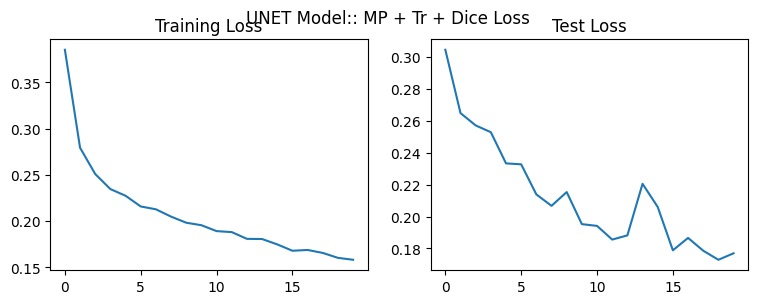

In [ ]:
plot_losses(train_losses,test_losses,title = "UNET Model:: MP + Tr + Dice Loss")

# 5.3 - TRAIN THE UNET MODEL  - StrConv + Tr + BCE  (cross entropy loss)

In [ ]:
my_unet = Unet(in_channels=3, out_channels=3,StrConv=True,ConvTr=True).to(device)
optimizer = torch.optim.Adam(params = my_unet.parameters(),lr=0.001)
print(summary(model= my_unet, input_size=(32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]))
train_losses,test_losses =  train_unet(EPOCHS,my_unet,ce_loss_fn,device,train_dataloader,test_dataloader)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                              [32, 3, 128, 128]    [32, 3, 128, 128]    --                   True
├─ContractingBlock (contract1)           [32, 3, 128, 128]    [32, 32, 64, 64]     --                   True
│    └─Conv2d (conv1)                    [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
│    └─BatchNorm2d (bn1)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu1)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (conv2)                    [32, 32, 128, 128]   [32, 32, 128, 128]   9,248                True
│    └─BatchNorm2d (bn2)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu2)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (str

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6803 | test_loss: 0.6588 
Epoch: 2 | train_loss: 0.5285 | test_loss: 0.5480 
Epoch: 3 | train_loss: 0.4446 | test_loss: 0.4573 
Epoch: 4 | train_loss: 0.4004 | test_loss: 0.3863 
Epoch: 5 | train_loss: 0.3717 | test_loss: 0.3804 
Epoch: 6 | train_loss: 0.3555 | test_loss: 0.3769 
Epoch: 7 | train_loss: 0.3373 | test_loss: 0.3552 
Epoch: 8 | train_loss: 0.3237 | test_loss: 0.3486 
Epoch: 9 | train_loss: 0.3125 | test_loss: 0.3312 
Epoch: 10 | train_loss: 0.2978 | test_loss: 0.3432 
Epoch: 11 | train_loss: 0.2892 | test_loss: 0.3478 
Epoch: 12 | train_loss: 0.2825 | test_loss: 0.3046 
Epoch: 13 | train_loss: 0.2762 | test_loss: 0.3009 
Epoch: 14 | train_loss: 0.2696 | test_loss: 0.3060 
Epoch: 15 | train_loss: 0.2583 | test_loss: 0.3033 
Epoch: 16 | train_loss: 0.2471 | test_loss: 0.3247 
Epoch: 17 | train_loss: 0.2490 | test_loss: 0.3089 
Epoch: 18 | train_loss: 0.2347 | test_loss: 0.2951 
Epoch: 19 | train_loss: 0.2279 | test_loss: 0.2941 
Epoch: 20 | train_los

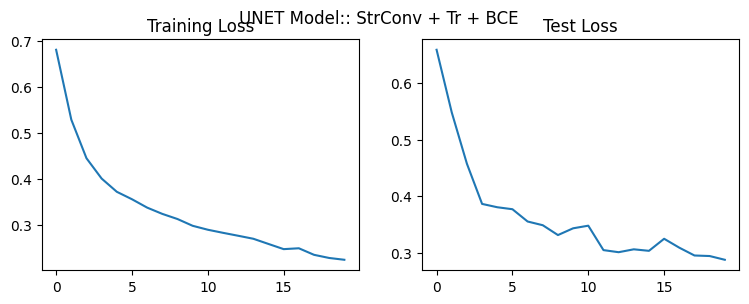

In [ ]:
plot_losses(train_losses,test_losses,title = "UNET Model:: StrConv + Tr + BCE")

# 5.4 - TRAIN THE UNET MODEL  - StrConv + Ups + Dice Loss

In [ ]:
my_unet = Unet(in_channels=3, out_channels=3,StrConv=True,ConvTr=False).to(device)
optimizer = torch.optim.Adam(params = my_unet.parameters(),lr=0.001)
print(summary(model= my_unet, input_size=(32,3,128,128), col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]))
train_losses,test_losses =  train_unet(EPOCHS,my_unet,dice_loss_fn,device,train_dataloader,test_dataloader)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Unet (Unet)                              [32, 3, 128, 128]    [32, 3, 128, 128]    --                   True
├─ContractingBlock (contract1)           [32, 3, 128, 128]    [32, 32, 64, 64]     --                   True
│    └─Conv2d (conv1)                    [32, 3, 128, 128]    [32, 32, 128, 128]   896                  True
│    └─BatchNorm2d (bn1)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu1)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (conv2)                    [32, 32, 128, 128]   [32, 32, 128, 128]   9,248                True
│    └─BatchNorm2d (bn2)                 [32, 32, 128, 128]   [32, 32, 128, 128]   64                   True
│    └─ReLU (relu2)                      [32, 32, 128, 128]   [32, 32, 128, 128]   --                   --
│    └─Conv2d (str

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3852 | test_loss: 0.2973 
Epoch: 2 | train_loss: 0.2866 | test_loss: 0.3055 
Epoch: 3 | train_loss: 0.2582 | test_loss: 0.2497 
Epoch: 4 | train_loss: 0.2451 | test_loss: 0.2326 
Epoch: 5 | train_loss: 0.2321 | test_loss: 0.2275 
Epoch: 6 | train_loss: 0.2232 | test_loss: 0.2103 
Epoch: 7 | train_loss: 0.2192 | test_loss: 0.2474 
Epoch: 8 | train_loss: 0.2121 | test_loss: 0.2160 
Epoch: 9 | train_loss: 0.2086 | test_loss: 0.2126 
Epoch: 10 | train_loss: 0.2022 | test_loss: 0.2084 
Epoch: 11 | train_loss: 0.1995 | test_loss: 0.2033 
Epoch: 12 | train_loss: 0.1952 | test_loss: 0.2054 
Epoch: 13 | train_loss: 0.1905 | test_loss: 0.2126 
Epoch: 14 | train_loss: 0.1869 | test_loss: 0.2047 
Epoch: 15 | train_loss: 0.1839 | test_loss: 0.2069 
Epoch: 16 | train_loss: 0.1833 | test_loss: 0.1826 
Epoch: 17 | train_loss: 0.1801 | test_loss: 0.1964 
Epoch: 18 | train_loss: 0.1766 | test_loss: 0.2001 
Epoch: 19 | train_loss: 0.1767 | test_loss: 0.1862 
Epoch: 20 | train_los

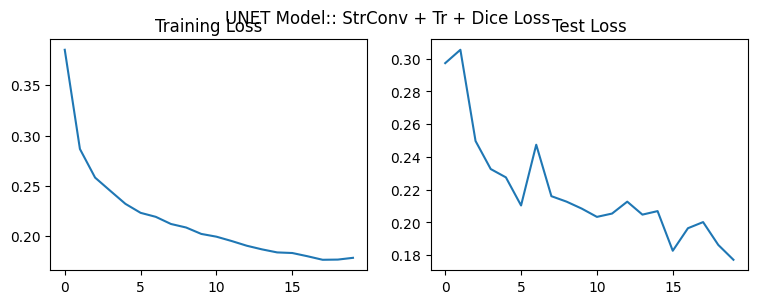

In [ ]:
plot_losses(train_losses,test_losses,title = "UNET Model:: StrConv + Tr + Dice Loss")

# 6 - Visualise predictions

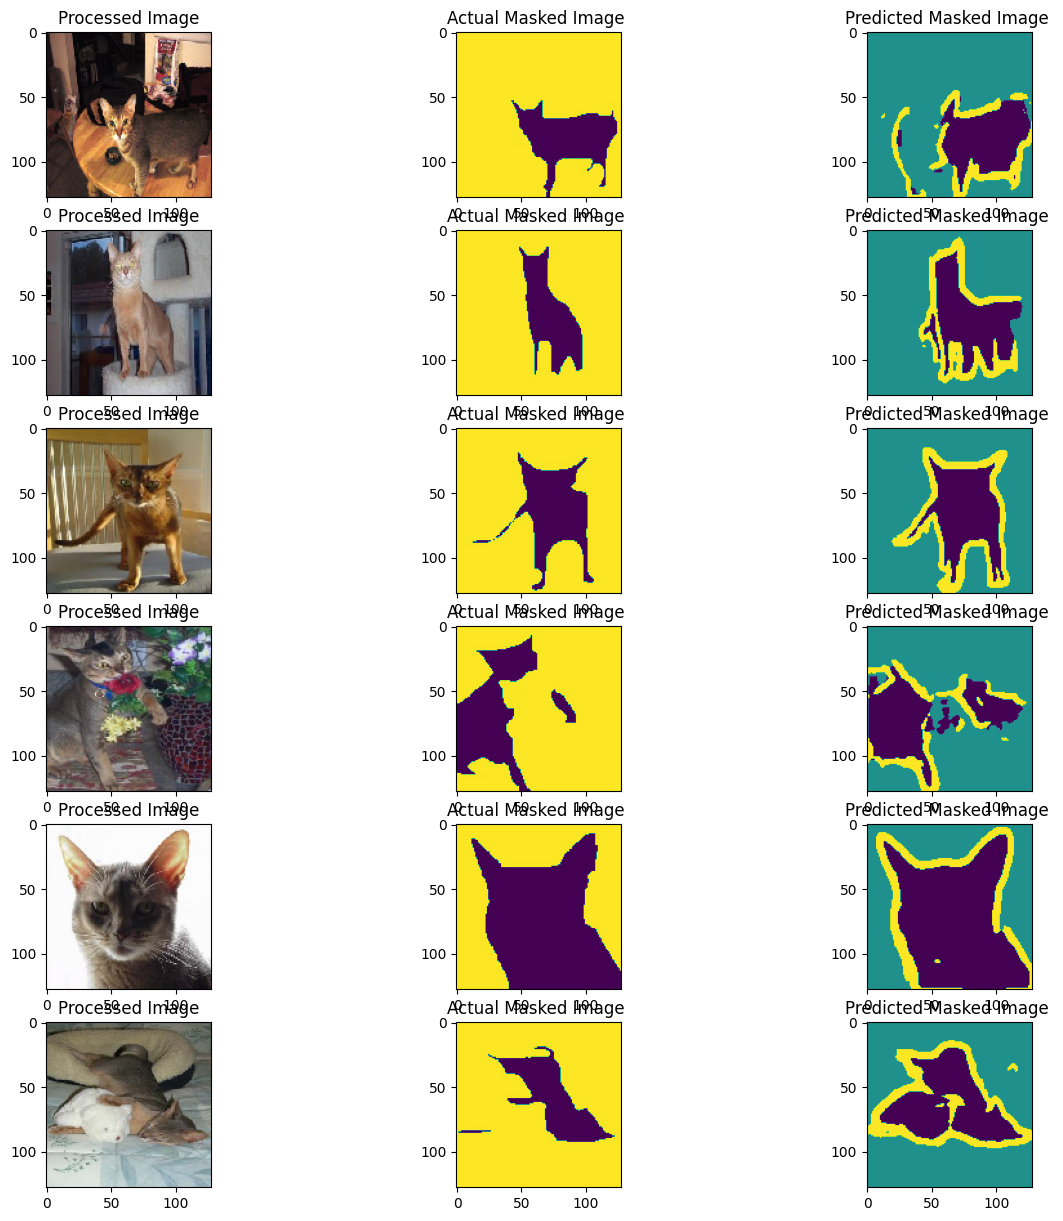

In [ ]:
def VisualizeResults(my_unet):
    my_unet.eval()
    my_unet.to('cpu')
    transform = T.ToPILImage()
    (test_pets_inputs, test_pets_targets) = next(iter(test_dataloader))
    fig, arr = plt.subplots(6, 3, figsize=(15, 15)) # batch size 16

    for index in range(6):
      img = test_pets_inputs[index].unsqueeze(0)
      pred_y = my_unet(img)
      pred_y = nn.Softmax(dim=1)(pred_y)
      pred_mask = pred_y.argmax(dim=1)
      pred_mask = pred_mask.unsqueeze(1).to(torch.float)


      arr[index,0].imshow(transform(test_pets_inputs[index]))
      arr[index,0].set_title('Processed Image')
      arr[index,1].imshow(transform(test_pets_targets[index].float()))
      arr[index,1].set_title('Actual Masked Image ')
      arr[index,2].imshow(pred_mask.squeeze(0).squeeze(0))
      arr[index,2].set_title('Predicted Masked Image ')

VisualizeResults(my_unet)